## ARMA Modeling: Forecasting

**Functions**

`tsa.SARIMAX.forecast`

### Exercise 46
Produce 1-step forecasts from your preferred model in the previous exercise, as well
as a random-walk model. 

1. Are the forecasts objectively accurate?
2. Compare these forecasts to the random walk models using MSE and MAE.

**Note**: Use 50% of the sample to estimate the model and 50% to evaluate it.

In [1]:
import pandas as pd
data = pd.read_hdf("data/term-premium.h5", "term_premium")
term = data["TERM"]

In [2]:
import statsmodels.tsa.api as tsa

nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  401
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -73.853
Date:                Wed, 26 Feb 2020   AIC                            155.707
Time:                        15:37:05   BIC                            171.682
Sample:                    04-01-1953   HQIC                           162.033
                         - 08-01-1986                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0560      0.022      2.519      0.012       0.012       0.100
ar.L1          0.8940      0.017     53.205      0.000       0.861       0.927
ma.L1          0.4575      0.020     22.584      0.000       0.418       0.497
sigma2         0.0841      0.003     26.506      0.000       0.078       0.090
===================================================================================
Ljung-Box (Q):                       74.26   Jarque-Bera (JB):               925.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.79   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

fcast = forecast_res.predict()

errors = term - fcast
oos_errors = errors.iloc[half:]

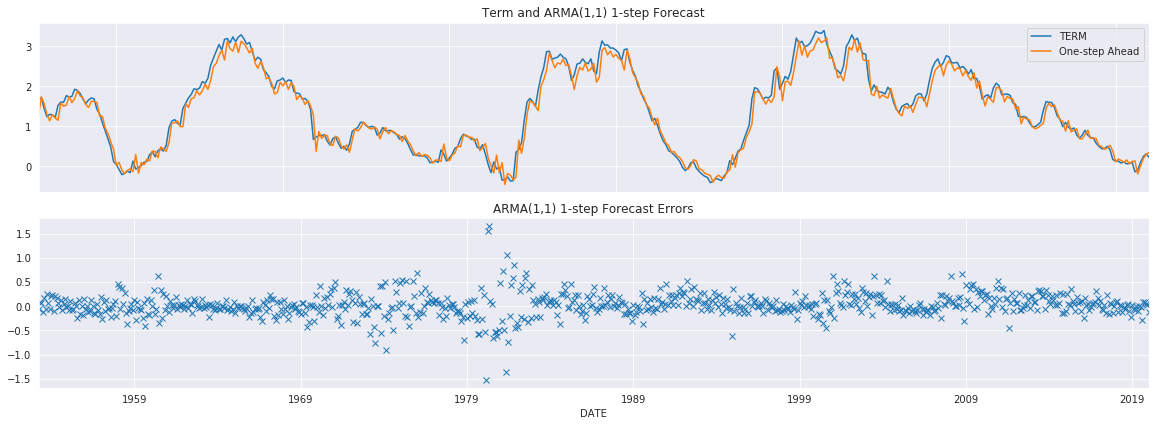

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,6))

both = pd.concat([term, fcast],1)
both.columns = ['TERM', "One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and ARMA(1,1) 1-step Forecast")
errors = both.TERM - both["One-step Ahead"]
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("ARMA(1,1) 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

In [5]:
import statsmodels.api as sm

oos_fcast = sm.add_constant(fcast.iloc[half:])
oos_fcast.columns = ["Const", "Forecast"]
res = sm.OLS(oos_errors, oos_fcast).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     45.75
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           4.81e-11
Time:                        15:37:07   Log-Likelihood:                 147.31
No. Observations:                 401   AIC:                            -290.6
Df Residuals:                     399   BIC:                            -282.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0170      0.015     -1.170      0.243      -0.045       0.012
Forecast       0.0590      0.009      6.764      0.000       0.042       0.076
==============================================================================
Omnibus:                       26.841   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.235
Skew:                           0.359   Prob(JB):                     3.73e-13
Kurtosis:                       4.706   Cond. No.                         3.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import numpy as np
r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[51.13672786]]), p=1.6950733595848664e-20, df_denom=399, df_num=2>

In [7]:
rw_forecast = term.shift(1)
both = pd.concat([term, rw_forecast],1)
rw_error = term - rw_forecast
rw_oos_error = rw_error.iloc[half:]
rw_forecast = sm.add_constant(rw_forecast)
rw_forecast = rw_forecast.iloc[half:]
rw_forecast.columns = ["Const", "One-step RW Forecast"]
res = sm.OLS(rw_oos_error, rw_forecast).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TERM   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.325
Date:                Wed, 26 Feb 2020   Prob (F-statistic):              0.128
Time:                        15:37:07   Log-Likelihood:                 127.72
No. Observations:                 401   AIC:                            -251.4
Df Residuals:                     399   BIC:                            -243.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Const                    0.0160      0.015      1.067      0.287      -0.013       0.046
One-step RW Forecast    -0.0130      0.009     -1.525      0.128      -0.030       0.004
==============================================================================
Omnibus:                       39.359   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.084
Skew:                           0.484   Prob(JB):                     5.03e-22
Kurtosis:                       5.221   Cond. No.                         3.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.20339162]]), p=0.3012614779272496, df_denom=399, df_num=2>

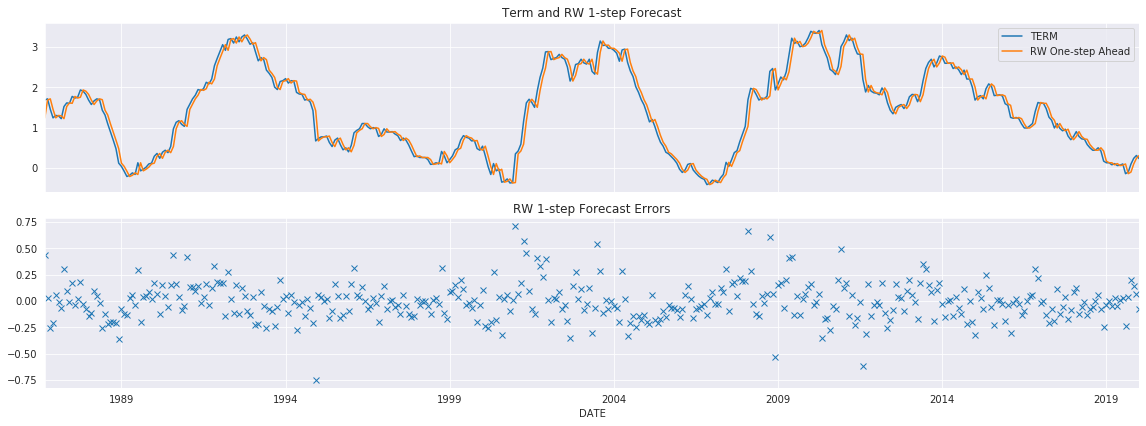

In [9]:
plt.rc("figure", figsize=(16,6))

both.columns = ['TERM', "RW One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and RW 1-step Forecast")

errors = rw_oos_error
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("RW 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

### Exercise 47

Produce 3-step forecasts from the models selected in the previous exercises as well as a random walk model.

1. Compare these forecasts to the random walk models using MSE and MAE.


In [10]:
nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

In [11]:
three_step = {}
for t in range(half, nobs):
    fcasts = forecast_res.predict(t, t+2, dynamic=True)
    key = fcasts.index[-1]
    value = fcasts.iloc[-1]
    three_step[key] = value
three_step = pd.Series(three_step)

In [12]:
three_step_errors = term - three_step
three_step_errors = three_step_errors.dropna()
three_step_errors


1986-11-01    0.319959
1986-12-01   -0.256720
1987-01-01   -0.061355
1987-02-01    0.147532
1987-03-01    0.204201
                ...   
2019-09-01   -0.303093
2019-10-01   -0.114303
2019-11-01    0.290045
2019-12-01    0.195894
2020-01-01   -0.025017
Length: 399, dtype: float64

In [13]:
three_step_rw = term.shift(3)
three_step_rw_errors = term - three_step_rw
three_step_rw_errors = three_step_rw_errors.iloc[half:]

In [14]:
errors = pd.DataFrame({"ARMA": three_step_errors, "RW": three_step_rw_errors}).dropna()
pd.DataFrame([(errors ** 2).mean(), errors.abs().mean()], index=['MSE', 'MAE'])

,ARMA,RW
MSE,0.214134,0.131924
MAE,0.355210,0.278822


In [15]:
d = errors["ARMA"] ** 2 - errors["RW"] ** 2
x = np.ones_like(d)
maxlags = int(d.shape[0] ** (1/3))
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                nan
Time:                        15:37:09   Log-Likelihood:                -26.011
No. Observations:                 399   AIC:                             54.02
Df Residuals:                     398   BIC:                             58.01
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0822      0.026      3.116      0.002       0.030       0.134
==============================================================================
Omnibus:                       85.265   Durbin-Watson:                   0.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.897
Skew:                           1.075   Prob(JB):                     1.06e-43
Kurtosis:                       5.698   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

In [16]:
d = errors["ARMA"].abs() - errors["RW"].abs()
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                nan
Time:                        15:37:09   Log-Likelihood:                -53.607
No. Observations:                 399   AIC:                             109.2
Df Residuals:                     398   BIC:                             113.2
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0764      0.027      2.787      0.005       0.023       0.130
==============================================================================
Omnibus:                        0.636   Durbin-Watson:                   0.535
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.748
Skew:                           0.076   Prob(JB):                        0.688
Kurtosis:                       2.852   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""